In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Stat"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays
using LinearAlgebra
using LogDensityProblems
using LogDensityProblemsAD

# Define the components of a basic model.
struct LogTargetDensity_Logistic
    a::Float64
    B::Float64
    n::Int64
end

LogDensityProblems.logdensity(p::LogTargetDensity_Logistic, ξ) = -log(2π * p.B) - (ξ[1] - p.a)^2/(2 * p.B) + ξ[1] - p.n * log(1 + exp(ξ[1]))
LogDensityProblems.dimension(p::LogTargetDensity_Logistic) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensity_Logistic}) = LogDensityProblems.LogDensityOrder{0}()

function MHSampler(n::Int64; discard_initial=30000)

    model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensity_Logistic(0.0, 100.0, n))

    spl = RWMH(MvNormal(zeros(1), I))

    chain = sample(model_with_ad, spl, 50000; chain_type=Chains, param_names=["ξ"])

    return chain
end

# ξ_vector = MHSampler(10000)
# plot(ξ_vector, title="Plot of \$\\xi\$ values", xlabel="Index", ylabel="ξ", legend=false, color="#78C2AD")

MHSampler (generic function with 1 method)

In [3]:
using DataFrames
using Plots

n_list = [10, 100, 1000, 10000]

elapsed_time_Metropolis = @elapsed begin
    chains = [MHSampler(n) for n in n_list]
end

autos = [DataFrame(autocor(chain, lags=1:100)) for chain in chains]

combined_df = vcat(autos..., source=:chain)

lag_columns = names(combined_df)[2:101]
lags = 1:100

p_Metropolis = plot(
    title = "Metropolis",
    xlabel = "Lag",
    ylabel = "Autocorrelation",
    legend = :topright
)

for (i, n) in zip(1:4, n_list)
    plot!(
        p_Metropolis,
        lags,
        Array(combined_df[i, lag_columns]),
        label = "n = $n",
        linewidth = 2
    )
end

Sampling:   1%|▍                                        |  ETA: 0:00:11

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [4]:
using PolyaGammaSamplers

function PGSampler(n::Int64; discard_initial=30000, iter_number=50000, initial_ξ=0.0, B=100)

    λ = 1 - n/2

    ξ_list = [initial_ξ]
    ω_list = []

    while length(ξ_list) < iter_number
        ξ = ξ_list[end]
        ω_sampler = PolyaGammaPSWSampler(n, ξ)
        ω_new = rand(ω_sampler)
        push!(ω_list, ω_new)
        ξ_sampler = Normal((ω_new + B^(-1))^(-1) * λ, (ω_new + B^(-1))^(-1))
        ξ_new = rand(ξ_sampler)
        push!(ξ_list, ξ_new)
    end

    return Chains(ξ_list[discard_initial+1:end])
end

PGSampler (generic function with 1 method)

In [5]:
elapsed_time_PolyaGamma = @elapsed begin
    chains = [PGSampler(n) for n in n_list]
end
autos = [DataFrame(autocor(chain, lags=1:100)) for chain in chains]

combined_df = vcat(autos..., source=:chain)

lag_columns = names(combined_df)[2:101]
lags = 1:100

p_PolyaGamma = plot(
    title = "Pólya-Gamma",
    xlabel = "Lag",
    ylabel = "Autocorrelation",
    legend = :topright
)

for (i, n) in zip(1:4, n_list)
    plot!(
        p_PolyaGamma,
        lags,
        Array(combined_df[i, lag_columns]),
        label = "n = $n",
        linewidth = 2
    )
end

In [6]:
println("Elapsed time: $elapsed_time_Metropolis seconds v.s. $elapsed_time_PolyaGamma seconds")

Elapsed time: 2.01934325 seconds v.s. 54.989071125 seconds


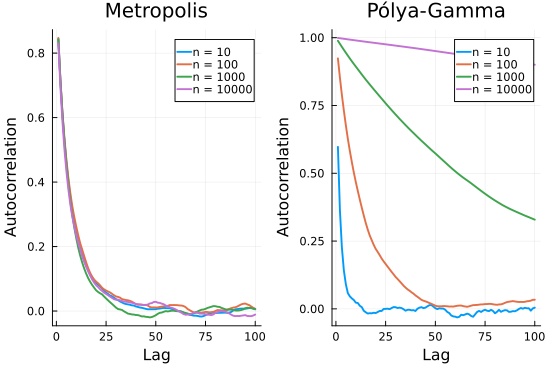

In [7]:
plot(p_Metropolis, p_PolyaGamma, layout=(1,2))